In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Markdown

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("equipment_anomaly_data.csv")
df.shape

(7672, 7)

In [9]:
df.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [17]:
df_cleaned = df.drop(columns=["equipment", "location"])
df_cleaned.head()

,temperature,pressure,vibration,humidity,faulty
0,58.180180,25.029278,0.606516,45.694907,0.0
1,75.740712,22.954018,2.338095,41.867407,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0
3,71.616985,32.242921,1.770690,40.565138,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0


In [19]:
X = df_cleaned.drop(columns=["faulty"])
X

,temperature,pressure,vibration,humidity
0,58.180180,25.029278,0.606516,45.694907
1,75.740712,22.954018,2.338095,41.867407
2,71.358594,27.276830,1.389198,58.954409
3,71.616985,32.242921,1.770690,40.565138
4,66.506832,45.197471,0.345398,43.253795
...,...,...,...,...
7667,65.711521,37.505934,2.030521,49.331471
7668,63.005855,45.164234,1.264585,61.905390
7669,72.029230,34.757896,1.709046,49.972917
7670,107.086485,23.754114,1.142522,23.967977


In [22]:
y = df_cleaned["faulty"]
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7667    0.0
7668    0.0
7669    0.0
7670    1.0
7671    1.0
Name: faulty, Length: 7672, dtype: float64

In [25]:
 scaler = StandardScaler()
 X_scaled = scaler.fit_transform(X)
 X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

In [27]:
 svm = SVC()
 svm.fit(X_train, y_train)
 svm_preds = svm.predict(X_test)

In [30]:
# Generate reports as dictionaries
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
svm_report = classification_report(y_test, svm_preds, output_dict=True)

# Convert to DataFrames and merge
rf_df = pd.DataFrame(rf_report).transpose()
svm_df = pd.DataFrame(svm_report).transpose()
combined_df = pd.concat(
    [rf_df.add_suffix('_RF'), svm_df.add_suffix('_SVM')], 
    axis=1
)

# Display with styling
print("\n=== Model Performance Comparison ===")
display(combined_df.style.background_gradient(cmap='Blues', subset=combined_df.columns[:-3]))


=== Model Performance Comparison ===


,precision_RF,recall_RF,f1-score_RF,support_RF,precision_SVM,recall_SVM,f1-score_SVM,support_SVM
0.0,0.985745,0.992821,0.989270,1393.000000,0.985117,0.997846,0.991441,1393.000000
1.0,0.924242,0.859155,0.890511,142.000000,0.975806,0.852113,0.909774,142.000000
accuracy,0.980456,0.980456,0.980456,0.980456,0.984365,0.984365,0.984365,0.984365
macro avg,0.954994,0.925988,0.939891,1535.000000,0.980462,0.924980,0.950608,1535.000000
weighted avg,0.980055,0.980456,0.980134,1535.000000,0.984256,0.984365,0.983886,1535.000000


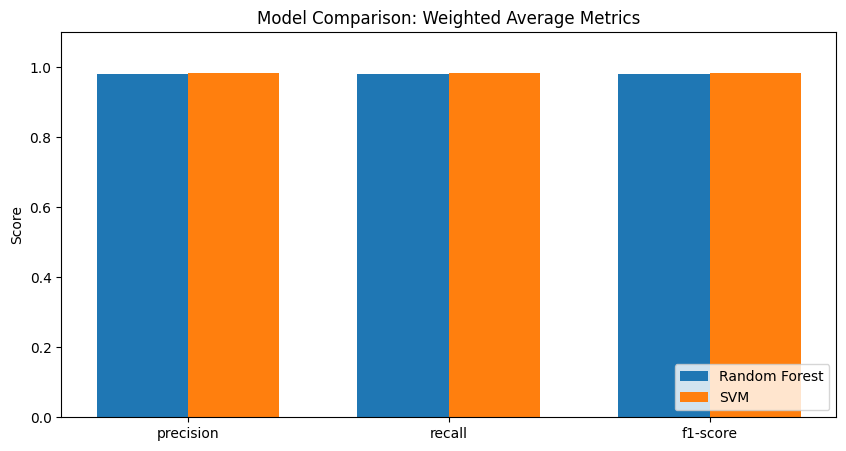

In [32]:
# Extract metrics for plotting
metrics = ['precision', 'recall', 'f1-score']
rf_metrics = [rf_report['weighted avg'][m] for m in metrics]
svm_metrics = [svm_report['weighted avg'][m] for m in metrics]

# Plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, rf_metrics, width, label='Random Forest', color='#1f77b4')
ax.bar(x + width/2, svm_metrics, width, label='SVM', color='#ff7f0e')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Weighted Average Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='lower right')
plt.ylim(0, 1.1)
plt.show()

In [34]:
# Generate markdown table
md_table = """
| Metric         | Random Forest | SVM     |
|----------------|---------------|---------|
| Accuracy       | {:.3f}        | {:.3f}  |
| Precision (Avg)| {:.3f}        | {:.3f}  |
| Recall (Avg)   | {:.3f}        | {:.3f}  |
| F1-Score (Avg) | {:.3f}        | {:.3f}  |
""".format(
    accuracy_score(y_test, rf_predictions),
    accuracy_score(y_test, svm_preds),
    rf_report['weighted avg']['precision'],
    svm_report['weighted avg']['precision'],
    rf_report['weighted avg']['recall'],
    svm_report['weighted avg']['recall'],
    rf_report['weighted avg']['f1-score'],
    svm_report['weighted avg']['f1-score']
)

display(Markdown(md_table))


| Metric         | Random Forest | SVM     |
|----------------|---------------|---------|
| Accuracy       | 0.980        | 0.984  |
| Precision (Avg)| 0.980        | 0.984  |
| Recall (Avg)   | 0.980        | 0.984  |
| F1-Score (Avg) | 0.980        | 0.984  |


In [ ]:
# Generate confusion matrices
rf_cm = confusion_matrix(y_test, rf_predictions)
svm_cm = confusion_matrix(y_test, svm_preds)

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
ConfusionMatrixDisplay(rf_cm, display_labels=['Normal', 'Faulty']).plot(ax=ax1, cmap='Blues')
ax1.set_title('Random Forest')

# SVM Confusion Matrix
ConfusionMatrixDisplay(svm_cm, display_labels=['Normal', 'Faulty']).plot(ax=ax2, cmap='Oranges')
ax2.set_title('SVM')

plt.suptitle('Confusion Matrices Comparison', y=1.02)
plt.tight_layout()
plt.savefig('images/confusion_matrices.png', bbox_inches='tight', dpi=300)
plt.show()